In [1]:
#from sage.all import *
import random #as pyrandom
import warnings
warnings.filterwarnings("ignore", message=".*Signature.*numpy.longdouble.*")
#da ni warningov


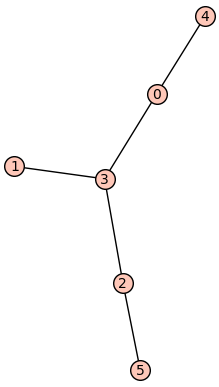

In [2]:
graphs.RandomTree(6).show()

In [3]:
#import random

def general_sombor_index(G, alpha):
    deg = G.degree()  
    val = 0
    for u, v in G.edges(labels=False):
        du = deg[u]
        dv = deg[v]
        val += (du**2 + dv**2)**alpha
    return RR(val)

def max_degree(G):
    return max(G.degree()) if G.num_verts() > 0 else 0


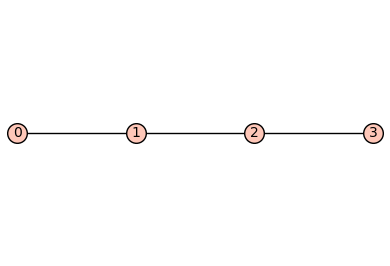

vozlišča: [0, 1, 2, 3]
povezave: [(0, 1), (1, 2), (2, 3)]
stopnje: [1, 2, 2, 1]
  α = 0.10  →  SO_α(G) = 3.58038229952095
  α = 0.50  →  SO_α(G) = 7.30056307974577
  α = 0.90  →  SO_α(G) = 15.0114183960577


In [4]:
#testiranje na primeru
G = graphs.PathGraph(4)
G.show()

print("vozlišča:", G.vertices())
print("povezave:", G.edges(labels=False))
print("stopnje:", G.degree())

alpha_values = [0.1, 0.5, 0.9]

for alpha in alpha_values:
    val = general_sombor_index(G, alpha)
    print(f"  α = {alpha:.2f}  →  SO_α(G) = {val}")


In [5]:
def systematic_best_trees(n, Delta, alpha, return_all_best=True):
    best_val = -infinity
    best_trees = []
    
    for T in graphs.trees(n):
        if max_degree(T) > Delta:
            continue
        
        val = general_sombor_index(T, alpha)
        if val > best_val + 1e-12:
            best_val = val
            best_trees = [T]
        elif abs(val - best_val) <= 1e-12 and return_all_best:
            best_trees.append(T)
    
    return best_val, best_trees

SO_1.00(G) = 114.000000000000

Ekstremi: 

Drevo 1:
stopnje vozlišč: [1, 1, 1, 1, 1, 1, 3, 3, 3, 3]
max stopnja: 3
povezave: [(0, 1), (0, 6), (0, 9), (1, 2), (1, 5), (2, 3), (2, 4), (6, 7), (6, 8)]


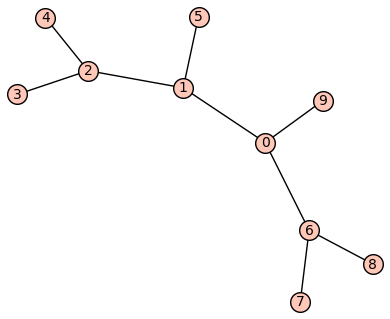

Drevo 2:
stopnje vozlišč: [1, 1, 1, 1, 1, 1, 3, 3, 3, 3]
max stopnja: 3
povezave: [(0, 1), (0, 4), (0, 7), (1, 2), (1, 3), (4, 5), (4, 6), (7, 8), (7, 9)]


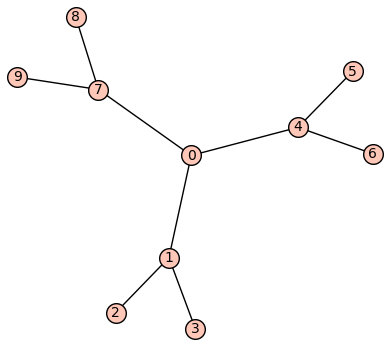

In [6]:
#testiranje na primeru
n = 10    
Delta = 3    
alpha = 1  

best_val, best_trees = systematic_best_trees(n, Delta, alpha)

print(f"SO_{alpha:.2f}(G) = {best_val}\n")

print("Ekstremi: \n")
for i, T in enumerate(best_trees, 1):
    print(f"Drevo {i}:")
    print("stopnje vozlišč:", sorted(T.degree()))
    print("max stopnja:", max_degree(T))
    print("povezave:", T.edges(labels=False))
    T.show()  


In [7]:
#alpha = 0.5
#P5 = graphs.PathGraph(5)
#Star = Graph()
#Star.add_vertices(range(5))
#Star.add_edges([(0,1), (0,2), (0,3), (0,4)])
#print("Degrees P5:   ", P5.degree())
#print("Degrees Star: ", Star.degree())
#print("\nGeneral Sombor index values (alpha = 0.5):")
#print("  SO_0.5(P5)   =", general_sombor_index(P5, alpha))
#print("  SO_0.5(Star) =", general_sombor_index(Star, alpha))
#P5.show()
#Star.show()


In [8]:
# Random tree with bounded maximum degree Δ

def random_bounded_degree_tree(n, Delta):
    """
    Generate a random n-vertex tree with maximum degree <= Delta.
    Simple incremental construction: start with one vertex and
    keep attaching new vertices to random existing vertices whose
    degree is still < Delta.
    
    Assumes Delta >= 2 and n >= 1.
    """
    #if n == 1:
    #    G = Graph()
    #    G.add_vertex(0)
    #   return G
    
    G = Graph()
    G.add_vertex(0)
    
    for v in range(1, n):
        # vertices with degree < Delta
        kandidati = [u for u in G.vertices() if G.degree(u) < Delta]
        #if not kandidati:
            # This should not happen for Delta >= 2, but we guard anyway:
            #raise ValueError("No available vertex to attach new node; try larger Delta.")
        
        parent = random.choice(kandidati)
        G.add_vertex(v)
        G.add_edge(v, parent)
    
    # Sanity check:
    #if max_degree(G) > Delta:
    #    raise RuntimeError("Generated tree violates degree constraint.")
    
    return G


In [9]:
#Local move on trees (for stochastic search)
# local move by relocating a leaf


def random_tree_move(G, Delta, max_attempts=50):
    """
    Simpler local move:
      - pick a random leaf ℓ with neighbor p,
      - detach ℓ from p,
      - attach ℓ to a different vertex q with degree < Delta.
    This keeps the graph a tree and respects the max degree constraint.
    """
    H = G.copy()
    
    for _ in range(max_attempts):
        # find all leaves (degree 1 vertices)
        leaves = [v for v in H.vertices() if H.degree(v) == 1]
        if not leaves:
            return G  # shouldn't happen in a tree, but safe fallback
        
        leaf = random.choice(leaves)
        neighbor = H.neighbors(leaf)[0]  # the unique neighbor of a leaf
        
        # candidates to be the new parent of the leaf
        candidates = [
            v for v in H.vertices()
            if v != leaf and v != neighbor and H.degree(v) < Delta
        ]
        
        if not candidates:
            # no valid place to move this leaf, try another leaf/attempt
            continue
        
        new_parent = random.choice(candidates)
        
        # perform the move: detach from old parent, attach to new parent
        H.delete_edge(leaf, neighbor)
        H.add_edge(leaf, new_parent)
        
        # sanity check (should always be true, but we guard anyway)
        if H.is_tree() and max_degree(H) <= Delta:
           return H
    
    # if all attempts fail, just return the original graph
    return G



In [10]:
#Stochastic hill-climbing search (for larger n)

def stochastic_best_tree(n, Delta, alpha, n_starts=20, n_steps=2000):
    """
    Stochastic search for trees maximizing the general Sombor index
    among n-vertex trees with maximum degree <= Delta.
    
    Uses multiple random restarts + simple hill-climbing (accepting moves
    that do not decrease SO_alpha).
    
    Parameters
    ----------
    n : int
    Delta : int
    alpha : float
    n_starts : int
        Number of random initial trees (multi-start).
    n_steps : int
        Number of local moves per start.
    verbose : bool
        If True, prints progress information.
        
    Returns
    -------
    (best_val, best_tree)
        best_val : RR
        best_tree : Graph
    """
    best_val = -infinity
    best_tree = None
    
    for s in range(n_starts):
        G = random_bounded_degree_tree(n, Delta)
        val = general_sombor_index(G, alpha)
        local_best_val = val
        local_best_tree = G
        
        #if verbose:
        #    print(f"[start {s+1}/{n_starts}] initial value = {val}")
        
        for step in range(n_steps):
            H = random_tree_move(G, Delta)
            if H is G:
                # No valid move found this attempt
                continue
            
            new_val = general_sombor_index(H, alpha)
            
            # Hill-climbing: accept if it does not decrease the value
            if new_val >= val - 1e-12:
                G, val = H, new_val
                if val > local_best_val + 1e-12:
                    local_best_val = val
                    local_best_tree = G
            
        #if verbose:
        #    print(f"  -> local best value = {local_best_val}")
        
        if local_best_val > best_val + 1e-12:
            best_val = local_best_val
            best_tree = local_best_tree
    
    return best_val, best_tree


In [11]:
# testiranje na primeru

n = 50
Delta = 4
alpha = 0.5

# Exact (exhaustive) search
#exact_val, exact_trees = systematic_best_trees(n, Delta, alpha)
#exact_degrees = sorted(exact_trees[0].degree())
#print("EXACT search:")
#print("  best value    =", exact_val)
#print("  degree seq    =", exact_degrees)

# Stochastic search
stoch_val, stoch_tree = stochastic_best_tree(
    n=n,
    Delta=Delta,
    alpha=alpha,
    n_starts=10,
    n_steps=2000
)
stoch_degrees = sorted(stoch_tree.degree())
#print("\nSTOCHASTIC search:")
print("vrednost =", stoch_val)
print("stopnje vozlišč =", stoch_degrees)



vrednost = 222.232154299798
stopnje vozlišč = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
